# Load Dataset

### Import Libraries

In [38]:
import os
from dotenv import load_dotenv
from pymongo import MongoClient
import pandas as pd

### Load Historical Prices

In [39]:
# Load environment variables
load_dotenv()

# MongoDB Connection Setup
MONGO_URI = os.getenv("MONGO_URI")
if not MONGO_URI:
    raise ValueError("MONGO_URI not found in environment variables. Please check your .env file.")

DATABASE_NAME = "robo_advisor"
HISTORICAL_PRICES_COLLECTION = "historical_prices"

# Load Historical Prices
def load_historical_prices():
    client = MongoClient(MONGO_URI)
    db = client[DATABASE_NAME]
    collection = db[HISTORICAL_PRICES_COLLECTION]
    
    # Fetch all historical prices
    data = list(collection.find({}, {"_id": 0}))  # Exclude MongoDB `_id` field for simplicity
    if not data:
        print("No data found in historical_prices collection.")
        return pd.DataFrame()
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    print(f"Loaded {len(df)} records from historical_prices collection.")
    return df

# Load and display
historical_prices_df = load_historical_prices()
historical_prices_df.head()

Loaded 883859 records from historical_prices collection.


,Date,Asset,Close,last_updated,last_updated_timestamp
0,2000-01-03,AAPL,0.999442,2024-11-13,2024-11-13 00:00:13.234
1,2000-01-04,AAPL,0.915179,2024-11-13,2024-11-13 00:00:13.234
2,2000-01-05,AAPL,0.928571,2024-11-13,2024-11-13 00:00:13.234
3,2000-01-19,AAPL,0.951451,2024-11-13,2024-11-13 00:00:13.234
4,2000-01-07,AAPL,0.888393,2024-11-13,2024-11-13 00:00:13.234


### Load Asset Metadata

In [40]:
# Asset Metadata Collection
ASSET_METADATA_COLLECTION = "asset_metadata"

# Load Asset Metadata
def load_asset_metadata():
    client = MongoClient(MONGO_URI)
    db = client[DATABASE_NAME]
    collection = db[ASSET_METADATA_COLLECTION]
    
    # Fetch all asset metadata
    data = list(collection.find({}, {"_id": 0}))  # Exclude MongoDB `_id` field for simplicity
    if not data:
        print("No data found in asset_metadata collection.")
        return pd.DataFrame()
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    print(f"Loaded {len(df)} records from asset_metadata collection.")
    return df

# Load and display
asset_metadata_df = load_asset_metadata()
asset_metadata_df.head()

Loaded 116 records from asset_metadata collection.


,Ticker,Short Name,Long Name,Asset_Type,Sector,Industry,Exchange,Currency,Description,1Y,...,Dividend Frequency,Market Cap,Beta,Risk Level,Annual_Volatility,Daily_Volatility,Monthly_Volatility,Quarterly_Volatility,Risk_Adjusted_1Y,Risk_Adjusted_YTD
0,AMD,"Advanced Micro Devices, Inc.","Advanced Micro Devices, Inc.",EQUITY,Technology,Semiconductors,NMS,USD,"Advanced Micro Devices, Inc. operates as a sem...",12.411087,...,N/A,223.49 billion,1.706,High Risk,0.594082,0.037424,0.171497,0.297041,20.891191,-1.323974
1,COKE,"Coca-Cola Consolidated, Inc.","Coca-Cola Consolidated, Inc.",EQUITY,Consumer Defensive,Beverages - Non-Alcoholic,NMS,USD,"Coca-Cola Consolidated, Inc., together with it...",75.794679,...,Quarterly,11.78 billion,0.842,Low Risk,0.331289,0.020869,0.095635,0.165645,228.787030,109.629582
2,EA,Electronic Arts Inc.,Electronic Arts Inc.,EQUITY,Communication Services,Electronic Gaming & Multimedia,NMS,USD,"Electronic Arts Inc. develops, markets, publis...",23.638537,...,Quarterly,43.28 billion,0.781,Low Risk,0.466941,0.029415,0.134794,0.233470,50.624274,51.852756
3,IEF,iShares 7-10 Year Treasury Bond,iShares 7-10 Year Treasury Bond ETF,ETF,N/A,N/A,NGM,USD,The underlying index measures the performance ...,1.170480,...,Monthly,N/A,N/A,Unknown,0.069515,0.004379,0.020067,0.034757,16.837858,-40.146785
4,JPM,JP Morgan Chase & Co.,JPMorgan Chase & Co.,EQUITY,Financial Services,Banks - Diversified,NYQ,USD,JPMorgan Chase & Co. operates as a financial s...,63.196507,...,Quarterly,703.75 billion,1.091,Moderate Risk,5.521320,0.347810,1.593868,2.760660,11.445905,7.649650


# Data Cleaning

Ensure all data is clean and consistent:
- Handle missing values (e.g., impute or drop).
- Normalize date formats (e.g., consistent Date fields).
- Standardize numerical fields (e.g., ensure returns, volatility are floats).
- Drop irrelevant or redundant fields.

### Check if there are any missing values

Visualizing missing values for 'historical_prices':
No missing values detected.

Visualizing missing values for 'asset_metadata':
Total missing values: 18


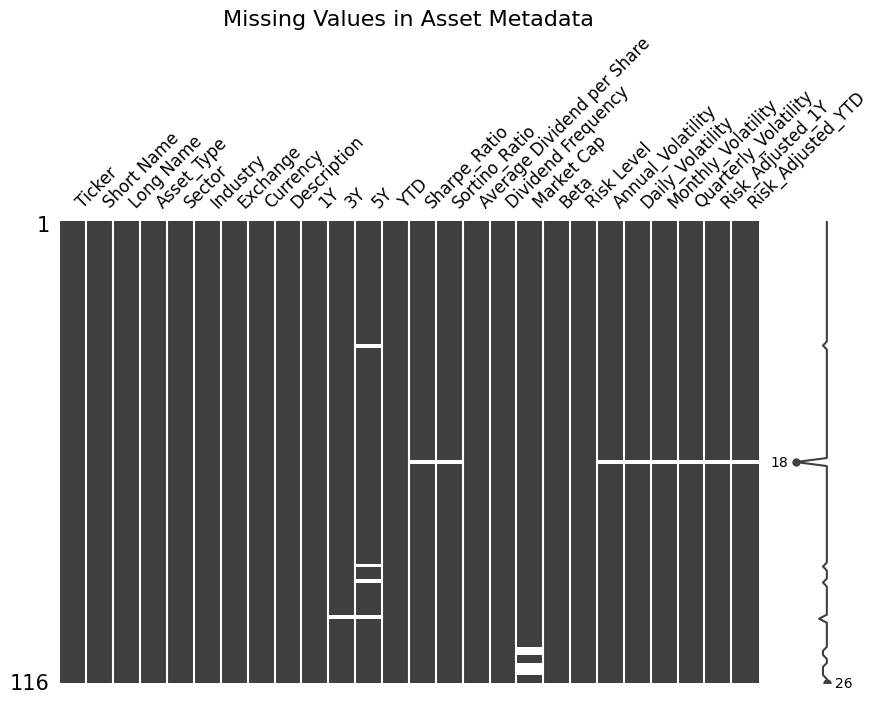

In [41]:
import missingno as msno
import matplotlib.pyplot as plt

# Function to visualize missing values
def visualize_missing_values(df, title="Missing Values"):
    if df.isnull().sum().sum() == 0:
        print("No missing values detected.")
        return
    
    print(f"Total missing values: {df.isnull().sum().sum()}")
    msno.matrix(df, figsize=(10, 6), fontsize=12)
    plt.title(title, fontsize=16)
    plt.show()

# Visualize missing values for historical_prices
print("Visualizing missing values for 'historical_prices':")
visualize_missing_values(historical_prices_df, title="Missing Values in Historical Prices")

# Visualize missing values for asset_metadata
print("\nVisualizing missing values for 'asset_metadata':")
visualize_missing_values(asset_metadata_df, title="Missing Values in Asset Metadata")

### Analyze missing market cap 

In [43]:
# Filter the DataFrame for rows where Market Cap is NaN
missing_market_cap_tickers = asset_metadata_df[asset_metadata_df["Market Cap"].isna()]["Ticker"].tolist()

# Print the tickers
print("Tickers with missing Market Cap:", missing_market_cap_tickers)

Tickers with missing Market Cap: ['FNGU', 'INDU', 'NDX', 'NQX', 'USD']


### Update Missing Market Cap for unsupported tickers

In [44]:
# Assign 'N/A' for unsupported tickers
unsupported_tickers = ["FNGU", "INDU", "NDX", 'NQX', "USD"]
asset_metadata_df.loc[asset_metadata_df["Ticker"].isin(unsupported_tickers), "Market Cap"] = "N/A"

print(asset_metadata_df)

    Ticker                       Short Name  \
0      AMD     Advanced Micro Devices, Inc.   
1     COKE     Coca-Cola Consolidated, Inc.   
2       EA             Electronic Arts Inc.   
3      IEF  iShares 7-10 Year Treasury Bond   
4      JPM            JP Morgan Chase & Co.   
..     ...                              ...   
111    NDX                NASDAQ 100 PR USD   
112    NQX                              N/A   
113    USD   ProShares Ultra Semiconductors   
114   USLM  United States Lime & Minerals,    
115   WLFC  Willis Lease Finance Corporatio   

                               Long Name Asset_Type                  Sector  \
0           Advanced Micro Devices, Inc.     EQUITY              Technology   
1           Coca-Cola Consolidated, Inc.     EQUITY      Consumer Defensive   
2                   Electronic Arts Inc.     EQUITY  Communication Services   
3    iShares 7-10 Year Treasury Bond ETF        ETF                     N/A   
4                   JPMorgan Chase & Co.

### Analyze missing returns

In [45]:
# Check for tickers with missing 1Y return
missing_1y_tickers = asset_metadata_df[asset_metadata_df["1Y"].isna()]["Ticker"].tolist()
print("Tickers with missing 1Y returns:", missing_1y_tickers)

# Check for tickers with missing 3Y return
missing_3y_tickers = asset_metadata_df[asset_metadata_df["3Y"].isna()]["Ticker"].tolist()
print("Tickers with missing 3Y returns:", missing_3y_tickers)

# Check for tickers with missing 5Y return
missing_5y_tickers = asset_metadata_df[asset_metadata_df["5Y"].isna()]["Ticker"].tolist()
print("Tickers with missing 5Y returns:", missing_5y_tickers)

# Check for tickers with missing YTD return
missing_ytd_tickers = asset_metadata_df[asset_metadata_df["YTD"].isna()]["Ticker"].tolist()
print("Tickers with missing YTD returns:", missing_ytd_tickers)

Tickers with missing 1Y returns: []
Tickers with missing 3Y returns: ['XBB']
Tickers with missing 5Y returns: ['PLTR', 'RIVN', 'SNOW', 'XBB']
Tickers with missing YTD returns: []


### Check the earliest date for available data

In [46]:
tickers_to_check = ['PLTR', 'RIVN', 'SNOW', 'XBB']

# Ensure 'Date' is in datetime format
historical_prices_df['Date'] = pd.to_datetime(historical_prices_df['Date'], errors='coerce')

# Filter rows and compute the minimum date for each ticker
min_dates = (
    historical_prices_df[historical_prices_df['Asset'].isin(tickers_to_check)]
    .groupby('Asset')['Date']
    .min()
)

print(min_dates)

Asset
PLTR   2020-09-30
RIVN   2021-11-10
SNOW   2020-09-17
XBB    2022-05-26
Name: Date, dtype: datetime64[ns]


### Normalize date formats

In [47]:
# Normalize 'Date' column in the historical_prices DataFrame
def normalize_date_format(df, date_column="Date"):
    """
    Normalize the format of the Date column in a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the date column.
        date_column (str): Name of the date column to normalize.

    Returns:
        pd.DataFrame: DataFrame with normalized date format.
    """
    if date_column not in df.columns:
        print(f"Column '{date_column}' not found in DataFrame.")
        return df

    # Convert to datetime, handle errors, and format as YYYY-MM-DD
    df[date_column] = pd.to_datetime(df[date_column], errors="coerce")
    
    # Identify rows with invalid dates
    invalid_dates = df[date_column].isnull().sum()
    if invalid_dates > 0:
        print(f"Warning: {invalid_dates} invalid dates found. They have been set to NaT.")
    
    return df

# Normalize the 'Date' column in the historical_prices DataFrame
historical_prices_df = normalize_date_format(historical_prices_df, date_column="Date")

# Display sample data
print(historical_prices_df.head())

        Date Asset     Close last_updated  last_updated_timestamp
0 2000-01-03  AAPL  0.999442   2024-11-13 2024-11-13 00:00:13.234
1 2000-01-04  AAPL  0.915179   2024-11-13 2024-11-13 00:00:13.234
2 2000-01-05  AAPL  0.928571   2024-11-13 2024-11-13 00:00:13.234
3 2000-01-19  AAPL  0.951451   2024-11-13 2024-11-13 00:00:13.234
4 2000-01-07  AAPL  0.888393   2024-11-13 2024-11-13 00:00:13.234


### Find duplicated data

In [51]:
# Find duplicates based on the combination of 'Date' and 'Asset'
duplicates_in_historical = historical_prices_df[historical_prices_df.duplicated(subset=['Date', 'Asset'], keep=False)]

# Displaying duplicates
print("Duplicates in historical_prices_df based on Date and Asset:")
print(duplicates_in_historical)

Duplicates in historical_prices_df based on Date and Asset:
             Date Asset     Close         last_updated  last_updated_timestamp
0      2000-01-03  AAPL  0.999442           2024-11-13 2024-11-13 00:00:13.234
1      2000-01-04  AAPL  0.915179           2024-11-13 2024-11-13 00:00:13.234
2      2000-01-05  AAPL  0.928571           2024-11-13 2024-11-13 00:00:13.234
3      2000-01-19  AAPL  0.951451           2024-11-13 2024-11-13 00:00:13.234
4      2000-01-07  AAPL  0.888393           2024-11-13 2024-11-13 00:00:13.234
...           ...   ...       ...                  ...                     ...
883854 2014-12-02  INDU  17879.55  2024-11-27 01:07:54 2024-11-27 01:07:54.813
883855 2014-12-01  INDU   17776.8  2024-11-27 01:07:54 2024-11-27 01:07:54.813
883856 2014-11-28  INDU  17828.24  2024-11-27 01:07:54 2024-11-27 01:07:54.813
883857 2014-11-27  INDU  17827.75  2024-11-27 01:07:54 2024-11-27 01:07:54.813
883858 2014-11-26  INDU  17827.75  2024-11-27 01:07:54 2024-11-27 01:07

### Find value counts of categorical columns

In [52]:
# Identify categorical columns (dtype = object or category)
categorical_columns = asset_metadata_df.select_dtypes(include=['object', 'category']).columns

# Compute value counts for each categorical column
for col in categorical_columns:
    print(f"Value counts for '{col}':")
    print(asset_metadata_df[col].value_counts())
    print("-" * 30)

Value counts for 'Ticker':
Ticker
AMD     1
COKE    1
EA      1
IEF     1
JPM     1
       ..
NDX     1
NQX     1
USD     1
USLM    1
WLFC    1
Name: count, Length: 116, dtype: int64
------------------------------
Value counts for 'Short Name':
Short Name
Advanced Micro Devices, Inc.       1
Coca-Cola Consolidated, Inc.       1
Electronic Arts Inc.               1
iShares 7-10 Year Treasury Bond    1
JP Morgan Chase & Co.              1
                                  ..
NASDAQ 100 PR USD                  1
N/A                                1
ProShares Ultra Semiconductors     1
United States Lime & Minerals,     1
Willis Lease Finance Corporatio    1
Name: count, Length: 116, dtype: int64
------------------------------
Value counts for 'Long Name':
Long Name
Advanced Micro Devices, Inc.           1
Coca-Cola Consolidated, Inc.           1
Electronic Arts Inc.                   1
iShares 7-10 Year Treasury Bond ETF    1
JPMorgan Chase & Co.                   1
                      

### Feature Importance

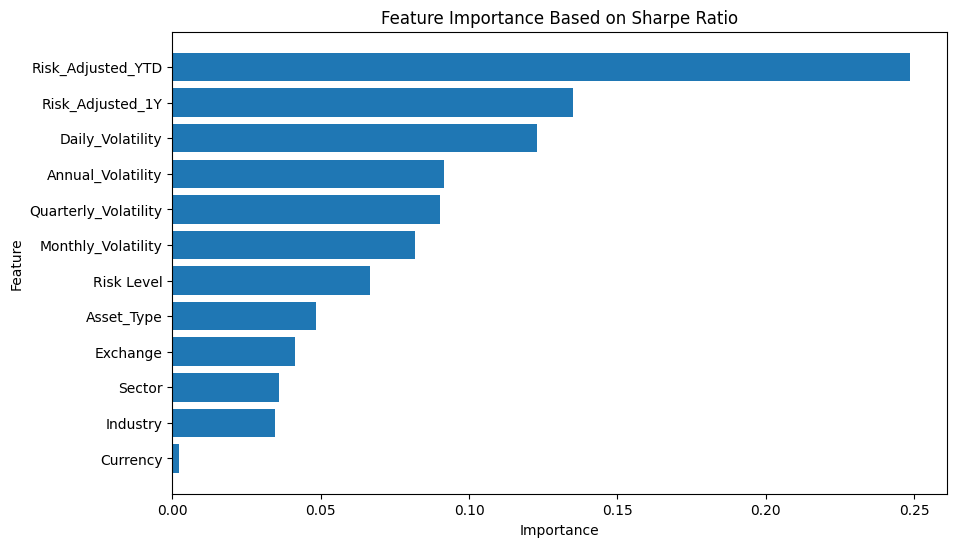

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

data = asset_metadata_df.copy()

# Define target and features
target = 'Sharpe_Ratio'  # Use Sharpe Ratio as the target for importance
numerical_features = ['Annual_Volatility', 'Daily_Volatility', 'Monthly_Volatility', 
                      'Quarterly_Volatility', 'Risk_Adjusted_1Y', 'Risk_Adjusted_YTD']
categorical_features = ['Asset_Type', 'Sector', 'Industry', 'Exchange', 'Currency', 'Risk Level']

# Encode categorical columns
label_encoder = LabelEncoder()
for col in categorical_features:
    data[col] = label_encoder.fit_transform(data[col].astype(str))

# Combine numerical and categorical features
features = numerical_features + categorical_features
X = data[features]
y = data[target]

# Handle missing values
X = X.fillna(0)
y = y.fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Feature Importance
importance = model.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Based on Sharpe Ratio')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()
